In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.energy_consumption import Energy2011
from src.Constants import Constants
sns.set_theme(style="ticks")
import numpy as np

# 1. Energy consumption in buildings

In [4]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [5]:
constants = Constants()

In [6]:
heat = pd.read_csv('../data/vinkovci_grijanje_2011.csv')
ele = pd.read_csv('../data/vinkovci_struja_2011.csv')

In [7]:
charts = Energy2011()

In [8]:
heat['potrošnja_energije(MWh)'] = heat['potrošnja_energije(kWh)'] / 1000

In [9]:
constants.co2_electricity_mwh_ton_2011

0.23231976036985194

In [10]:
co2_factors = {
    "električna energija": constants.co2_electricity_mwh_ton_2011,
    "Dizel": constants.co2_diesel_mwh_ton,
    "Benzin": constants.co2_petrol_mwh_ton,
    "UNP": constants.co2_lpg_mwh_ton,
    "prirodni plin": constants.co2_natgas_mwh_ton,
    "ogrjevno drvo": constants.co2_wood_mwh_ton,
    "lož ulje": constants.co2_heatoil_mwh_ton  # Corresponds to heat oil
}

In [11]:
seaborn_palette = sns.color_palette()

colors = {
    'lož ulje': seaborn_palette[1],  # 'orange'
    'električna energija': seaborn_palette[0],  # 'blue'
    'prirodni plin': seaborn_palette[3],  # 'red'
    'ogrjevno drvo': seaborn_palette[2]  # 'green'
}

In [12]:
heat['Emisije CO2 (t)'] = heat.apply(lambda row: row['potrošnja_energije(MWh)'] * co2_factors[row['energent']], axis=1)

In [13]:
tablica_1 = heat.pivot_table(
    index=['nadkategorija', 'kategorija', 'broj zgrada', 'ukupna_grijana_površina', 
           'specifična_potrošnja_energije(kWh/m2)'],
    columns='energent', 
    values='potrošnja_energije(MWh)',
    aggfunc='sum',
    fill_value=0
).groupby('kategorija').sum()

In [14]:
tablica_1_co2 = heat.pivot_table(
    index=['nadkategorija', 'kategorija', 'broj zgrada', 'ukupna_grijana_površina', 
           'specifična_potrošnja_energije(kWh/m2)'],
    columns='energent', 
    values='Emisije CO2 (t)',
    aggfunc='sum',
    fill_value=0
).groupby('kategorija').sum()

In [15]:
toplina_izvor = charts.heat_by_source()
toplina_sektor = charts.energy_by_sector('heat')
struja_sektor = charts.energy_by_sector('electricity')
gas_by_type = charts.gas_by_type()
gas_by_category = charts.gas_by_category()
illumination = charts.illumination()

/home/dionizije/Documents/vk_secap/src/energy_consumption.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby('energent').sum().reset_index()


KeyError: 'potrošnja_toplinske_energije(kWh)'

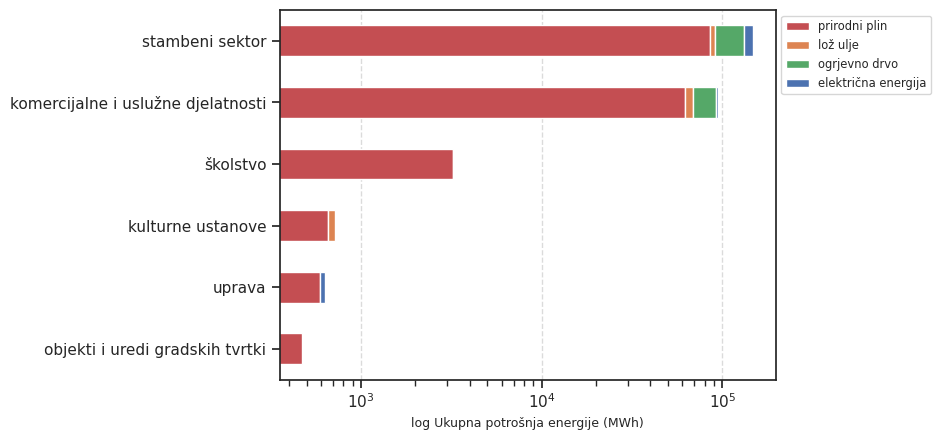

In [16]:
heat_pivot = heat.pivot(index='kategorija', columns='energent', values='potrošnja_energije(MWh)').fillna(0)
order = ['prirodni plin', 'lož ulje', 'ogrjevno drvo', 'električna energija']
heat_pivot = heat_pivot[order]
heat_pivot['Total'] = heat_pivot.sum(axis=1)
heat_pivot = heat_pivot.sort_values(by='Total', ascending=True).drop(columns=['Total'])


# Plot
fig, ax = plt.subplots()
heat_pivot.plot(kind='barh', stacked=True, ax=ax, width=0.5, color=[colors[energent] for energent in heat_pivot.columns])
threshold = 50000  # adjust this threshold as needed
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Set x-label and remove y-label
ax.set_xlabel("log Ukupna potrošnja energije (MWh)", fontsize=9)
ax.set_ylabel("")
ax.set_xscale('log')

# Adjust legend
legend = ax.legend(fontsize='x-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='x-small')

# Layout adjustment for accommodating the legend outside the plot

plt.show()

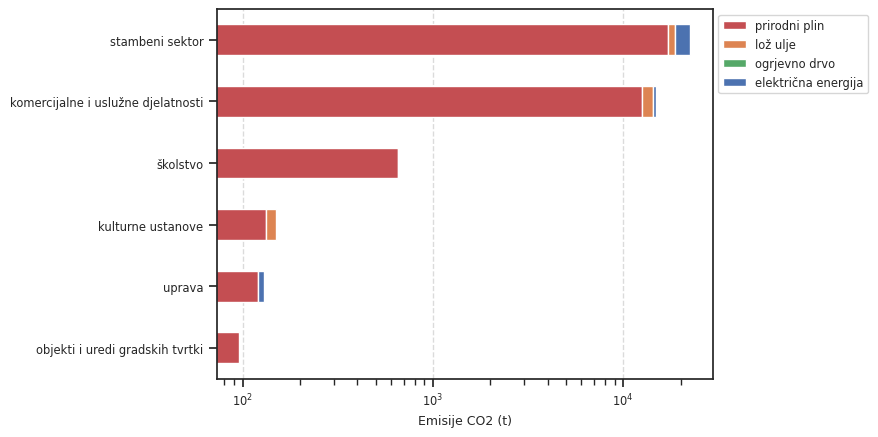

In [17]:
heat_co2_pivot = heat.pivot(index='kategorija', columns='energent', values='Emisije CO2 (t)').fillna(0)
order = ['prirodni plin', 'lož ulje', 'ogrjevno drvo', 'električna energija']
heat_co2_pivot = heat_co2_pivot[order]
heat_co2_pivot['Total'] = heat_co2_pivot.sum(axis=1)
heat_co2_pivot = heat_co2_pivot.sort_values(by='Total', ascending=True).drop(columns=['Total'])


# Plot
fig, ax = plt.subplots()
heat_co2_pivot.plot(kind='barh', stacked=True, ax=ax, width=0.5, color=[colors[energent] for energent in heat_co2_pivot.columns])
threshold = 50000  # adjust this threshold as needed
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Set x-label and remove y-label
ax.set_xlabel("Emisije CO2 (t)", fontsize=9)
ax.set_ylabel("")
ax.set_xscale('log')

# Adjust legend
legend = ax.legend(fontsize='x-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='x-small')

# Layout adjustment for accommodating the legend outside the plot

plt.show()

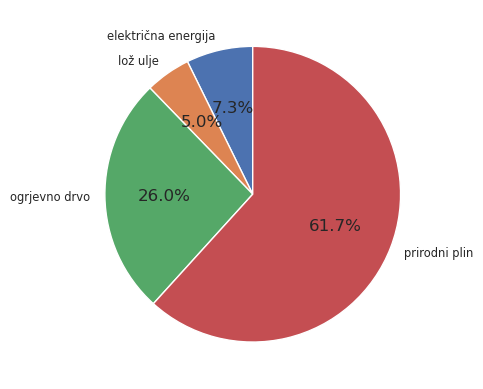

In [18]:
heat_pie_1 = heat.groupby('energent')['potrošnja_energije(MWh)'].sum()
ax = heat_pie_1.plot.pie(autopct='%1.1f%%', startangle=90, colors=[colors[energent] for energent in heat_pie_1.index])
ax.set_ylabel('')  # remove y-label
plt.show()

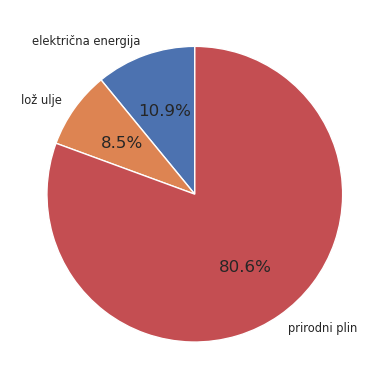

In [19]:
heat_co2_pie_1 = heat.groupby('energent')['Emisije CO2 (t)'].sum().drop('ogrjevno drvo')
ax = heat_co2_pie_1.plot.pie(autopct='%1.1f%%', startangle=90, colors=[colors[energent] for energent in heat_co2_pie_1.index])
ax.set_ylabel('')  # remove y-label
plt.show()

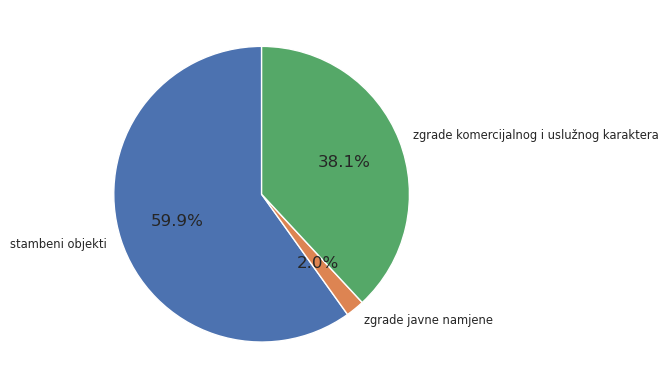

In [20]:
heat_pie_2 = heat.groupby('nadkategorija')['potrošnja_energije(MWh)'].sum()
ax = heat_pie_2.plot.pie(autopct='%1.1f%%', startangle=90)
ax.set_ylabel('')  # remove y-label
plt.show()

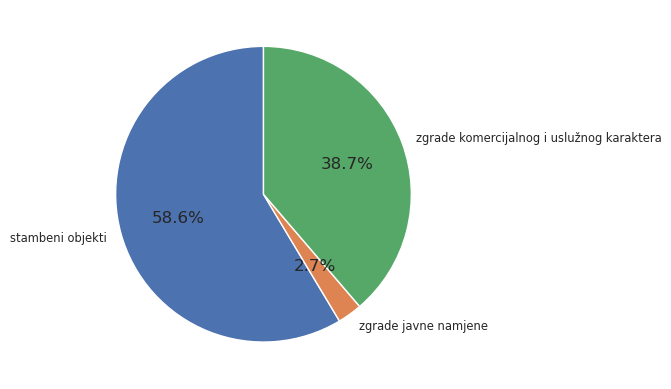

In [21]:
heat_co_pie_2 = heat.groupby('nadkategorija')['Emisije CO2 (t)'].sum()
ax = heat_co_pie_2.plot.pie(autopct='%1.1f%%', startangle=90)
ax.set_ylabel('')  # remove y-label
plt.show()

* CO2 heat

In [22]:
tablica_1_co2

energent,električna energija,lož ulje,ogrjevno drvo,prirodni plin
kategorija,,,,
komercijalne i uslužne djelatnosti,543.7,1700.5,0,12586.1
kulturne ustanove,0.0,16.7,0,132.9
objekti i uredi gradskih tvrtki,0.0,0.0,0,95.6
stambeni sektor,3634.9,1520.6,0,17283.7
uprava,8.8,0.0,0,119.9
školstvo,0.0,4.0,0,650.3


In [23]:
tablica_1_co2.sum()

energent
električna energija    4187.4
lož ulje               3241.9
ogrjevno drvo             0.0
prirodni plin         30868.6
dtype: float64

In [24]:
tablica_1_co2.sum().sum()

38297.86441327803

* Električna energija

In [25]:
ele['potrošnja_energije(MWh)'] = ele['potrošnja_energije(kWh)'] / 1000

In [26]:
ele['Emisije CO2 (t)'] = ele['potrošnja_energije(MWh)'] * co2_factors['električna energija']

In [27]:
ele.groupby('kategorija').sum()

/tmp/ipykernel_508231/1793770793.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ele.groupby('kategorija').sum()


,broj zgrada,potrošnja_energije(kWh),specifična_potrošnja_energije(kWh/m2),potrošnja_energije(MWh),Emisije CO2 (t)
kategorija,,,,,
komercijalne i uslužne djelatnosti,397,27390000,35.0,27390.0,6363.2
kulturne ustanove,7,125700,19.0,125.7,29.2
objekti i uredi gradskih tvrtki,6,98861,27.2,98.9,23.0
stambeni sektor,13326,54014000,40.8,54014.0,12548.5
uprava,14,121466,57.0,121.5,28.2
školstvo,13,455890,43.0,455.9,105.9


In [28]:
ele.groupby('kategorija').sum().sum()

/tmp/ipykernel_508231/215960477.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ele.groupby('kategorija').sum().sum()


broj zgrada                                13763.0
potrošnja_energije(kWh)                 82205917.0
specifična_potrošnja_energije(kWh/m2)        222.1
potrošnja_energije(MWh)                    82205.9
Emisije CO2 (t)                            19098.1
dtype: float64

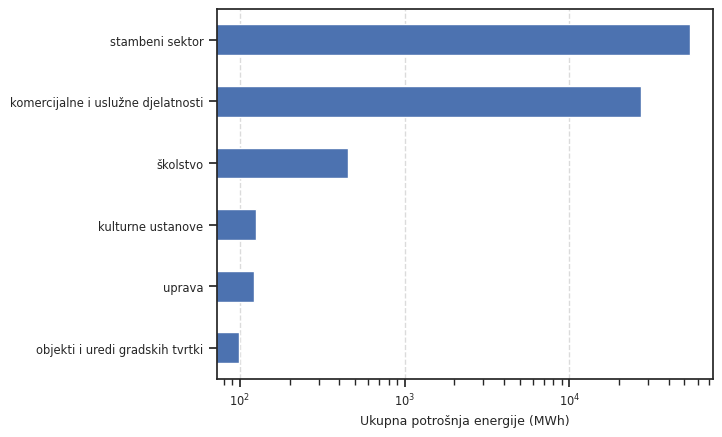

In [29]:
# Plot
fig, ax = plt.subplots()
ele_bar = ele.groupby('kategorija')['potrošnja_energije(MWh)'].sum()
ele_bar = ele_bar.sort_values(ascending=True).drop(columns=['Total'])
ele_bar.plot(kind='barh', stacked=True, ax=ax, width=0.5)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Set x-label and remove y-label
ax.set_xlabel("Ukupna potrošnja energije (MWh)", fontsize=9)
ax.set_ylabel("")
ax.set_xscale('log')

# Adjust legend

# Layout adjustment for accommodating the legend outside the plot

plt.show()

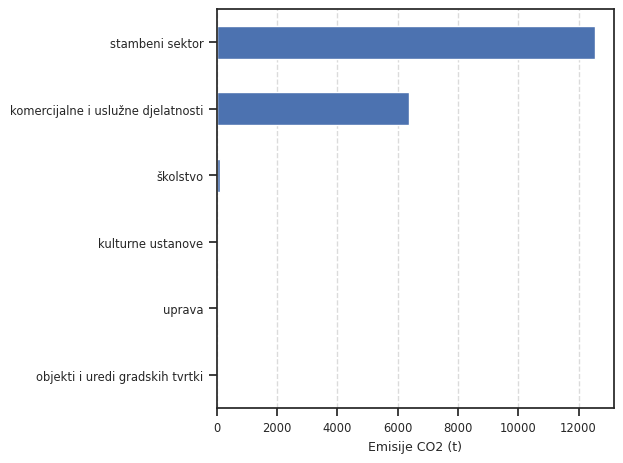

In [30]:
fig, ax = plt.subplots()
ele_co2_bar = ele.groupby('kategorija')['Emisije CO2 (t)'].sum()
ele_co2_bar = ele_co2_bar.sort_values(ascending=True)
ele_co2_bar.plot(kind='barh', ax=ax, width=0.5)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Set x-label and remove y-label
ax.set_xlabel("Emisije CO2 (t)", fontsize=9)
ax.set_ylabel("")

# Layout adjustment for accommodating the legend outside the plot
plt.tight_layout()

plt.show()

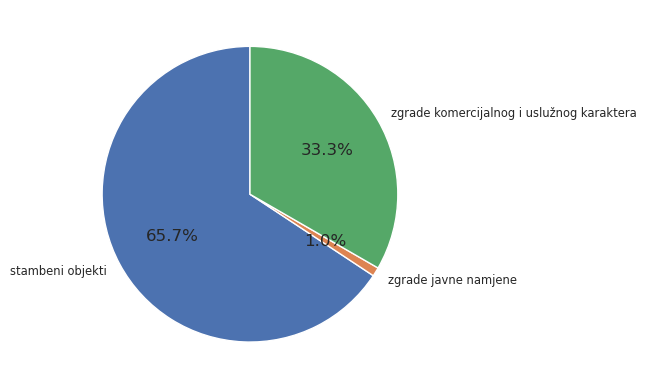

In [31]:
ele_pie_1 = ele.groupby('nadkategorija')['potrošnja_energije(MWh)'].sum()
ax = ele_pie_1.plot.pie(autopct='%1.1f%%', startangle=90)
ax.set_ylabel('')  # remove y-label
plt.show()

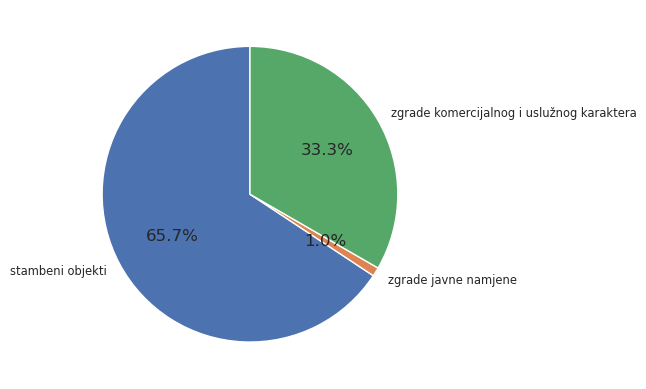

In [32]:
ele_co2_pie_1 = ele.groupby('nadkategorija')['Emisije CO2 (t)'].sum()
ax = ele_co2_pie_1.plot.pie(autopct='%1.1f%%', startangle=90)
ax.set_ylabel('')
plt.show()

## Traffic

In [100]:
trans = pd.read_csv('../data/2011/privatna_vozila_2011.csv')

In [101]:
trans = trans.fillna(0)

In [103]:
trans = trans.loc[trans['vrsta_prijevoza'] != 'taxi']

In [104]:
trans

,vrsta_prijevoza,broj,procijenjena_potrošena_masa_benzina(t),procijenjena_potrošena_masa_dizela(t),procijenjena_potrošena_masa_unp(t)
0,autobusni,6,0.0,13.9,0.0
2,osobna vozila,10005,2194.8,1047.0,44.9
3,teretna i radna vozila,2102,108.1,1557.0,0.0
4,mopedi i motocikli,910,53.0,0.0,0.0


In [107]:
trans['Dizel'] = trans['procijenjena_potrošena_masa_dizela(t)'] * constants.diesel_ton_mwh
trans['Benzin'] = trans['procijenjena_potrošena_masa_benzina(t)'] * constants.petrol_ton_mwh
trans['UNP'] = trans['procijenjena_potrošena_masa_unp(t)'] * constants.lpg_ton_mwh

/tmp/ipykernel_508231/302123579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans['Dizel'] = trans['procijenjena_potrošena_masa_dizela(t)'] * constants.diesel_ton_mwh
/tmp/ipykernel_508231/302123579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans['Benzin'] = trans['procijenjena_potrošena_masa_benzina(t)'] * constants.petrol_ton_mwh
/tmp/ipykernel_508231/302123579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [108]:
trans

,vrsta_prijevoza,broj,procijenjena_potrošena_masa_benzina(t),procijenjena_potrošena_masa_dizela(t),procijenjena_potrošena_masa_unp(t),Dizel,Benzin,UNP
0,autobusni,6,0.0,13.9,0.0,165.4,0.0,0.0
2,osobna vozila,10005,2194.8,1047.0,44.9,12459.3,26996.0,588.2
3,teretna i radna vozila,2102,108.1,1557.0,0.0,18528.3,1329.6,0.0
4,mopedi i motocikli,910,53.0,0.0,0.0,0.0,651.9,0.0


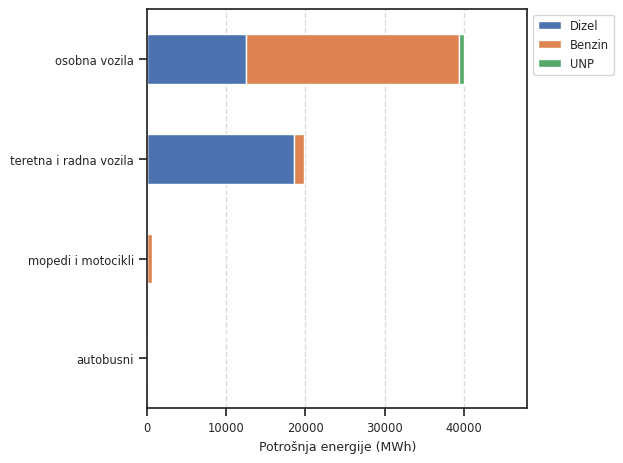

In [109]:
#df_pivot = trans.pivot(index='vrsta_prijevoza', columns=['energy_diesel', 'energy_petrol', 'energy_lpg']).fillna(0)
order = ['Dizel', 'Benzin', 'UNP']
trans_pivot = trans.set_index('vrsta_prijevoza')
trans_pivot = trans_pivot[order]
trans_pivot['Total'] = trans_pivot.sum(axis=1)
trans_pivot = trans_pivot.sort_values(by='Total', ascending=True).drop(columns=['Total'])


# Plot
fig, ax = plt.subplots()
trans_pivot.plot(kind='barh', stacked=True, ax=ax, width=0.5)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Set x-label and remove y-label
ax.set_xlabel("Potrošnja energije (MWh)", fontsize=9)
ax.set_xlim(0, trans_pivot.sum(axis=1).max() * 1.2)
ax.set_ylabel("")

# Adjust legend
legend = ax.legend(fontsize='x-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='x-small')

# Layout adjustment for accommodating the legend outside the plot
plt.tight_layout()
plt.show()

In [110]:
trans_pie_1 = trans_pivot.sum(axis=1)

In [120]:
trans_pie_1['ostalo'] = trans_pie_1['mopedi i motocikli'] + trans_pie_1['autobusni']

In [121]:
trans_pie_1 = trans_pie_1.drop(['mopedi i motocikli', 'autobusni'])

<Axes: >

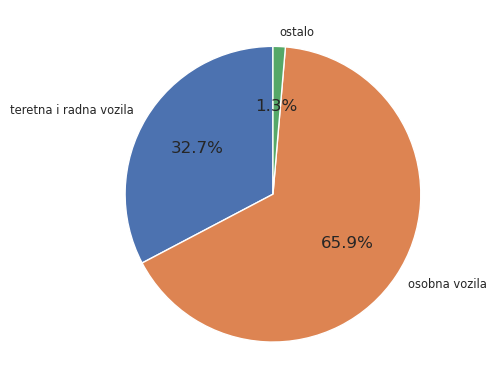

In [122]:
trans_pie_1.plot.pie(autopct='%1.1f%%', startangle=90)

In [40]:
trans_melted = trans_pivot.reset_index().melt(id_vars=['vrsta_prijevoza'], 
                                  value_vars=['Dizel', 'Benzin', 'UNP'],
                                  var_name='energent', 
                                  value_name='potrošnja_energije(MWh)')

Text(0, 0.5, '')

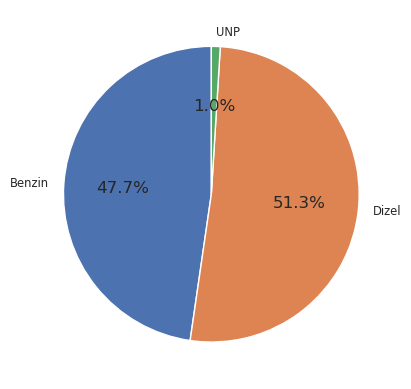

In [41]:
trans_pie_2 = trans_melted.groupby('energent')['potrošnja_energije(MWh)'].sum()
ax = trans_pie_2.plot.pie(autopct='%1.1f%%', startangle=90)
ax.set_ylabel('')

In [42]:
trans_melted['Emisije CO2 (t)'] = trans_melted.apply(lambda row: row['potrošnja_energije(MWh)'] * co2_factors[row['energent']], axis=1)

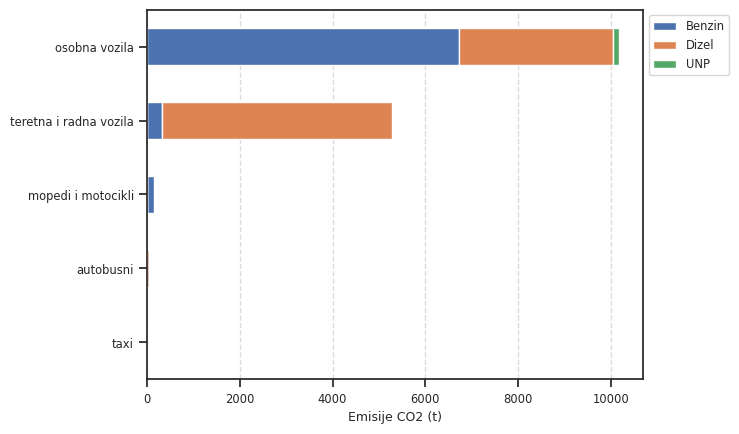

In [43]:
trans_co2_melted = trans_melted.pivot(index='vrsta_prijevoza', columns='energent', values='Emisije CO2 (t)').fillna(0)

order = ['Benzin', 'Dizel', 'UNP']
trans_co2_melted = trans_co2_melted[order]
trans_co2_melted['Total'] = trans_co2_melted.sum(axis=1)
trans_co2_melted = trans_co2_melted.sort_values(by='Total', ascending=True).drop(columns=['Total'])


# Plot
fig, ax = plt.subplots()
trans_co2_melted.plot(kind='barh', stacked=True, ax=ax, width=0.5)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Set x-label and remove y-label
ax.set_xlabel("Emisije CO2 (t)", fontsize=9)
ax.set_ylabel("")

# Adjust legend
legend = ax.legend(fontsize='x-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='x-small')


plt.show()

In [44]:
trans_co2_melted

energent,Benzin,Dizel,UNP
vrsta_prijevoza,,,
taxi,0.0,5.1,0.0
autobusni,0.0,44.2,0.0
mopedi i motocikli,162.3,0.0,0.0
teretna i radna vozila,331.1,4947.1,0.0
osobna vozila,6722.0,3326.6,133.5


<Axes: >

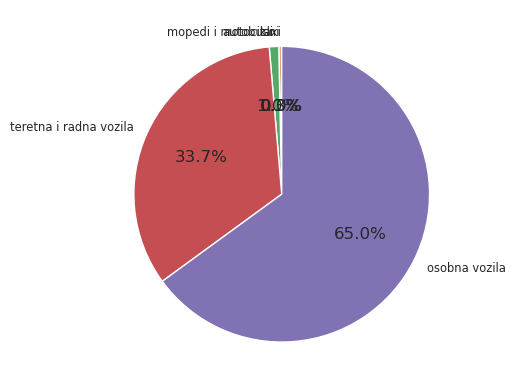

In [45]:
trans_co2_melted.sum(axis=1).plot.pie(autopct='%1.1f%%', startangle=90)

<Axes: >

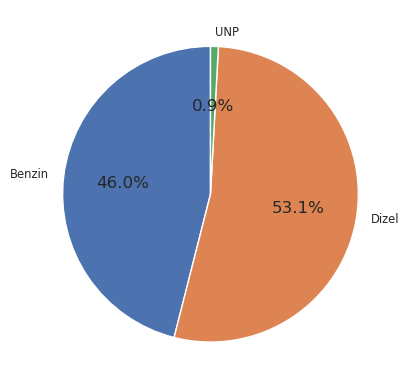

In [46]:
trans_co2_melted.sum().plot.pie(autopct='%1.1f%%', startangle=90)

* Total

In [47]:
ele['energent'] = 'električna energija'

In [48]:
trans_melted['sektor'] = 'promet'
ele['sektor'] = 'zgradarstvo'
heat['sektor'] = 'zgradarstvo'

In [49]:
columns = ['energent', 'potrošnja_energije(MWh)', 'Emisije CO2 (t)', 'sektor']
heat = heat[columns]
ele = ele[columns]
trans_melted = trans_melted[columns]

In [55]:
total = pd.concat([heat, ele, trans_melted])

In [57]:
total.loc[len(total)] = ['električna energija', 2922.5, 678.0, 'javna rasvjeta']

In [61]:
total.groupby(['energent', 'sektor'])['potrošnja_energije(MWh)'].sum()

energent             sektor        
Benzin               promet            28977.6
Dizel                promet            31172.1
UNP                  promet              588.2
električna energija  javna rasvjeta     2922.5
                     zgradarstvo      100230.3
lož ulje             zgradarstvo       12279.8
ogrjevno drvo        zgradarstvo       64439.4
prirodni plin        zgradarstvo      152814.7
Name: potrošnja_energije(MWh), dtype: float64

In [62]:
total.groupby(['energent', 'sektor'])['Emisije CO2 (t)'].sum()

energent             sektor        
Benzin               promet            7215.4
Dizel                promet            8322.9
UNP                  promet             133.5
električna energija  javna rasvjeta     678.0
                     zgradarstvo      23285.5
lož ulje             zgradarstvo       3241.9
ogrjevno drvo        zgradarstvo          0.0
prirodni plin        zgradarstvo      30868.6
Name: Emisije CO2 (t), dtype: float64

In [64]:
total.groupby('energent')['Emisije CO2 (t)'].sum().sum()

73745.79476170197

In [66]:
total.groupby('sektor')['Emisije CO2 (t)'].sum()

sektor
javna rasvjeta     678.0
promet           15671.9
zgradarstvo      57395.9
Name: Emisije CO2 (t), dtype: float64

In [77]:
total_bar = total.groupby(['sektor', 'energent']).agg({'potrošnja_energije(MWh)': 'sum'}).reset_index()
total_bar = total_bar.pivot(index='sektor', columns='energent', values='potrošnja_energije(MWh)').fillna(0)

[None, None]

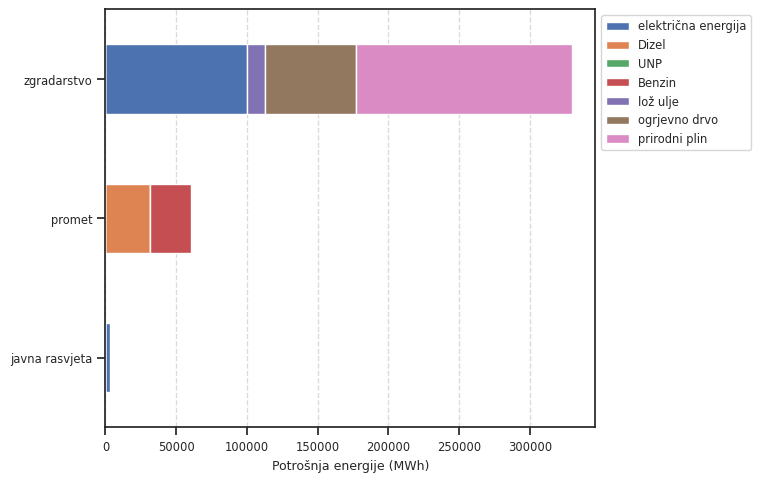

In [81]:
# Unstack the Series to get a DataFrame
order = ['električna energija', 'Dizel', 'UNP', 'Benzin', 'lož ulje', 'ogrjevno drvo', 'prirodni plin']
total_bar = total_bar[order]

# Plotting
fig, ax = plt.subplots()
ax = total_bar.plot(kind='barh', ax=ax, stacked=True, width=0.5)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.tight_layout()
ax.set_xlabel("Potrošnja energije (MWh)", fontsize=9)
ax.set_ylabel("")

# Adjust legend
legend = ax.legend(fontsize='x-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='x-small')

<Axes: ylabel='potrošnja_energije(MWh)'>

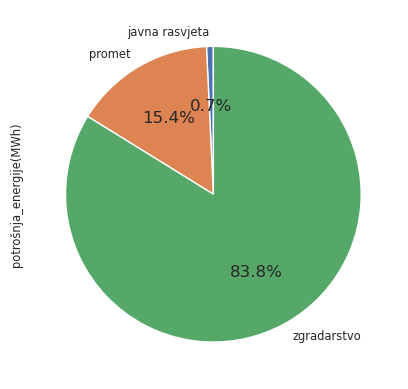

In [89]:
total.groupby('sektor')['potrošnja_energije(MWh)'].sum().plot.pie(autopct='%1.1f%%', startangle=90)

<Axes: ylabel='potrošnja_energije(MWh)'>

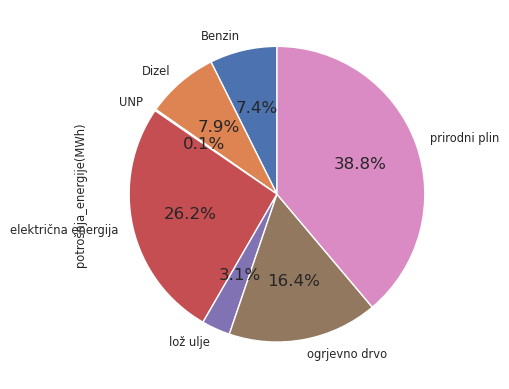

In [90]:
total.groupby('energent')['potrošnja_energije(MWh)'].sum().plot.pie(autopct='%1.1f%%', startangle=90)

In [83]:
total_co2_bar =  total.groupby(['sektor', 'energent']).agg({'Emisije CO2 (t)': 'sum'}).reset_index()
total_co2_bar = total_co2_bar.pivot(index='sektor', columns='energent', values='Emisije CO2 (t)').fillna(0)

[None, None]

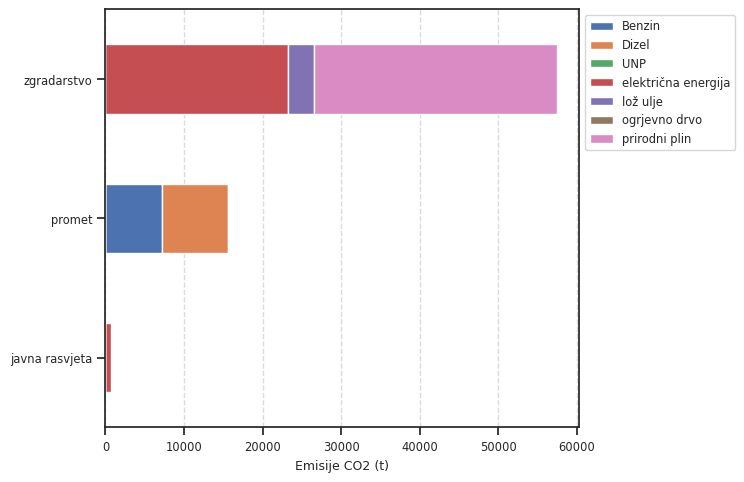

In [84]:
# Unstack the Series to get a DataFrame
order = ['električna energija', 'Dizel', 'UNP', 'Benzin', 'lož ulje', 'ogrjevno drvo', 'prirodni plin']
total_bar = total_co2_bar[order]

# Plotting
fig, ax = plt.subplots()
ax = total_co2_bar.plot(kind='barh', ax=ax, stacked=True, width=0.5)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.tight_layout()
ax.set_xlabel("Emisije CO2 (t)", fontsize=9)
ax.set_ylabel("")

# Adjust legend
legend = ax.legend(fontsize='x-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='x-small')

<Axes: ylabel='Emisije CO2 (t)'>

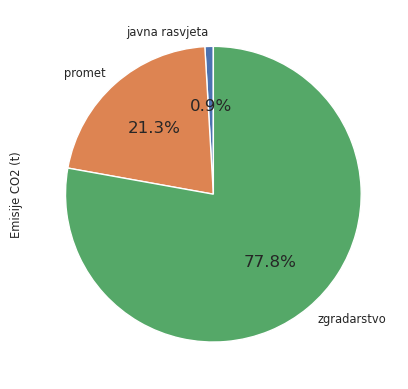

In [91]:
total.groupby('sektor')['Emisije CO2 (t)'].sum().plot.pie(autopct='%1.1f%%', startangle=90)

<Axes: ylabel='Emisije CO2 (t)'>

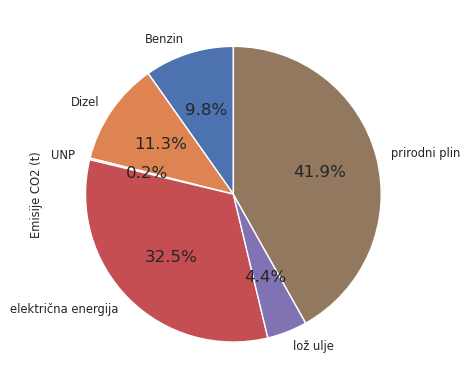

In [98]:
total.loc[total['energent'] != 'ogrjevno drvo'].groupby('energent')['Emisije CO2 (t)'].sum().plot.pie(autopct='%1.1f%%', startangle=90)